# Imports and library functions

In [157]:
from dataclasses import dataclass
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import plot_tree
from ydata_profiling import ProfileReport

from lib.chartSpecificData import survivalFrame
from lib.clean import cleanAge, cleanEmbarked, cleanFare, dropIrrelevant
from lib.featureEngineering import addFamilyCountData
from lib.numericConversion import (SexConversion, embarkedConverter,
                                   sexConverter)

### matplotlib options

This is just because my local setup is weird

In [158]:
matplotlib.use("ipympl")
plt.ioff()

## Compose
a function that enables functional composition
compose :: function, function, ... -> function

compose(f, g, h, i)(x) is equivalent to i(h(g(f(x))))

In [159]:
def compose(*funcs):
    return reduce(lambda f, g: lambda x: g(f(x)), funcs, lambda x: x)

## Import The Data

In [160]:

data: DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv"
)

# Data Exploration part 1

### Get the first few rows

In [161]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

### Get the last few rows

In [162]:
data.tail()

PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q

### Get summary, data types, that sort of thing

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Get descriptive statistics

In [164]:
data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

### Get number of nulls

In [165]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### ydataprofiler

In [166]:
# ProfileReport(data, title="Titanic Profiling Report")

# CCXZX%% data Preprocessing [markdown]
"""
# Data Preprocessing

Here we are just getting rid of null values and dropping irrelevant data that we don't need
"""

"\n# Data Preprocessing\n\nHere we are just getting rid of null values and dropping irrelevant data that we don't need\n"

In [167]:
cleanData = compose(cleanAge, cleanFare, cleanEmbarked, dropIrrelevant)
convertDataToNumeric = compose(sexConverter, embarkedConverter)

processedData = compose(cleanData, convertDataToNumeric)(data)
processedDataRows = len(processedData)

# Data Exploration Part II and Data Visualization

### ydata profiler again because catagorical data sucks

In [168]:
# ProfileReport(processedData, title="Titanic Profiling Report")

### Correlation Graph

### Pairplot
this is a way of looking at a lot of graphs quickly

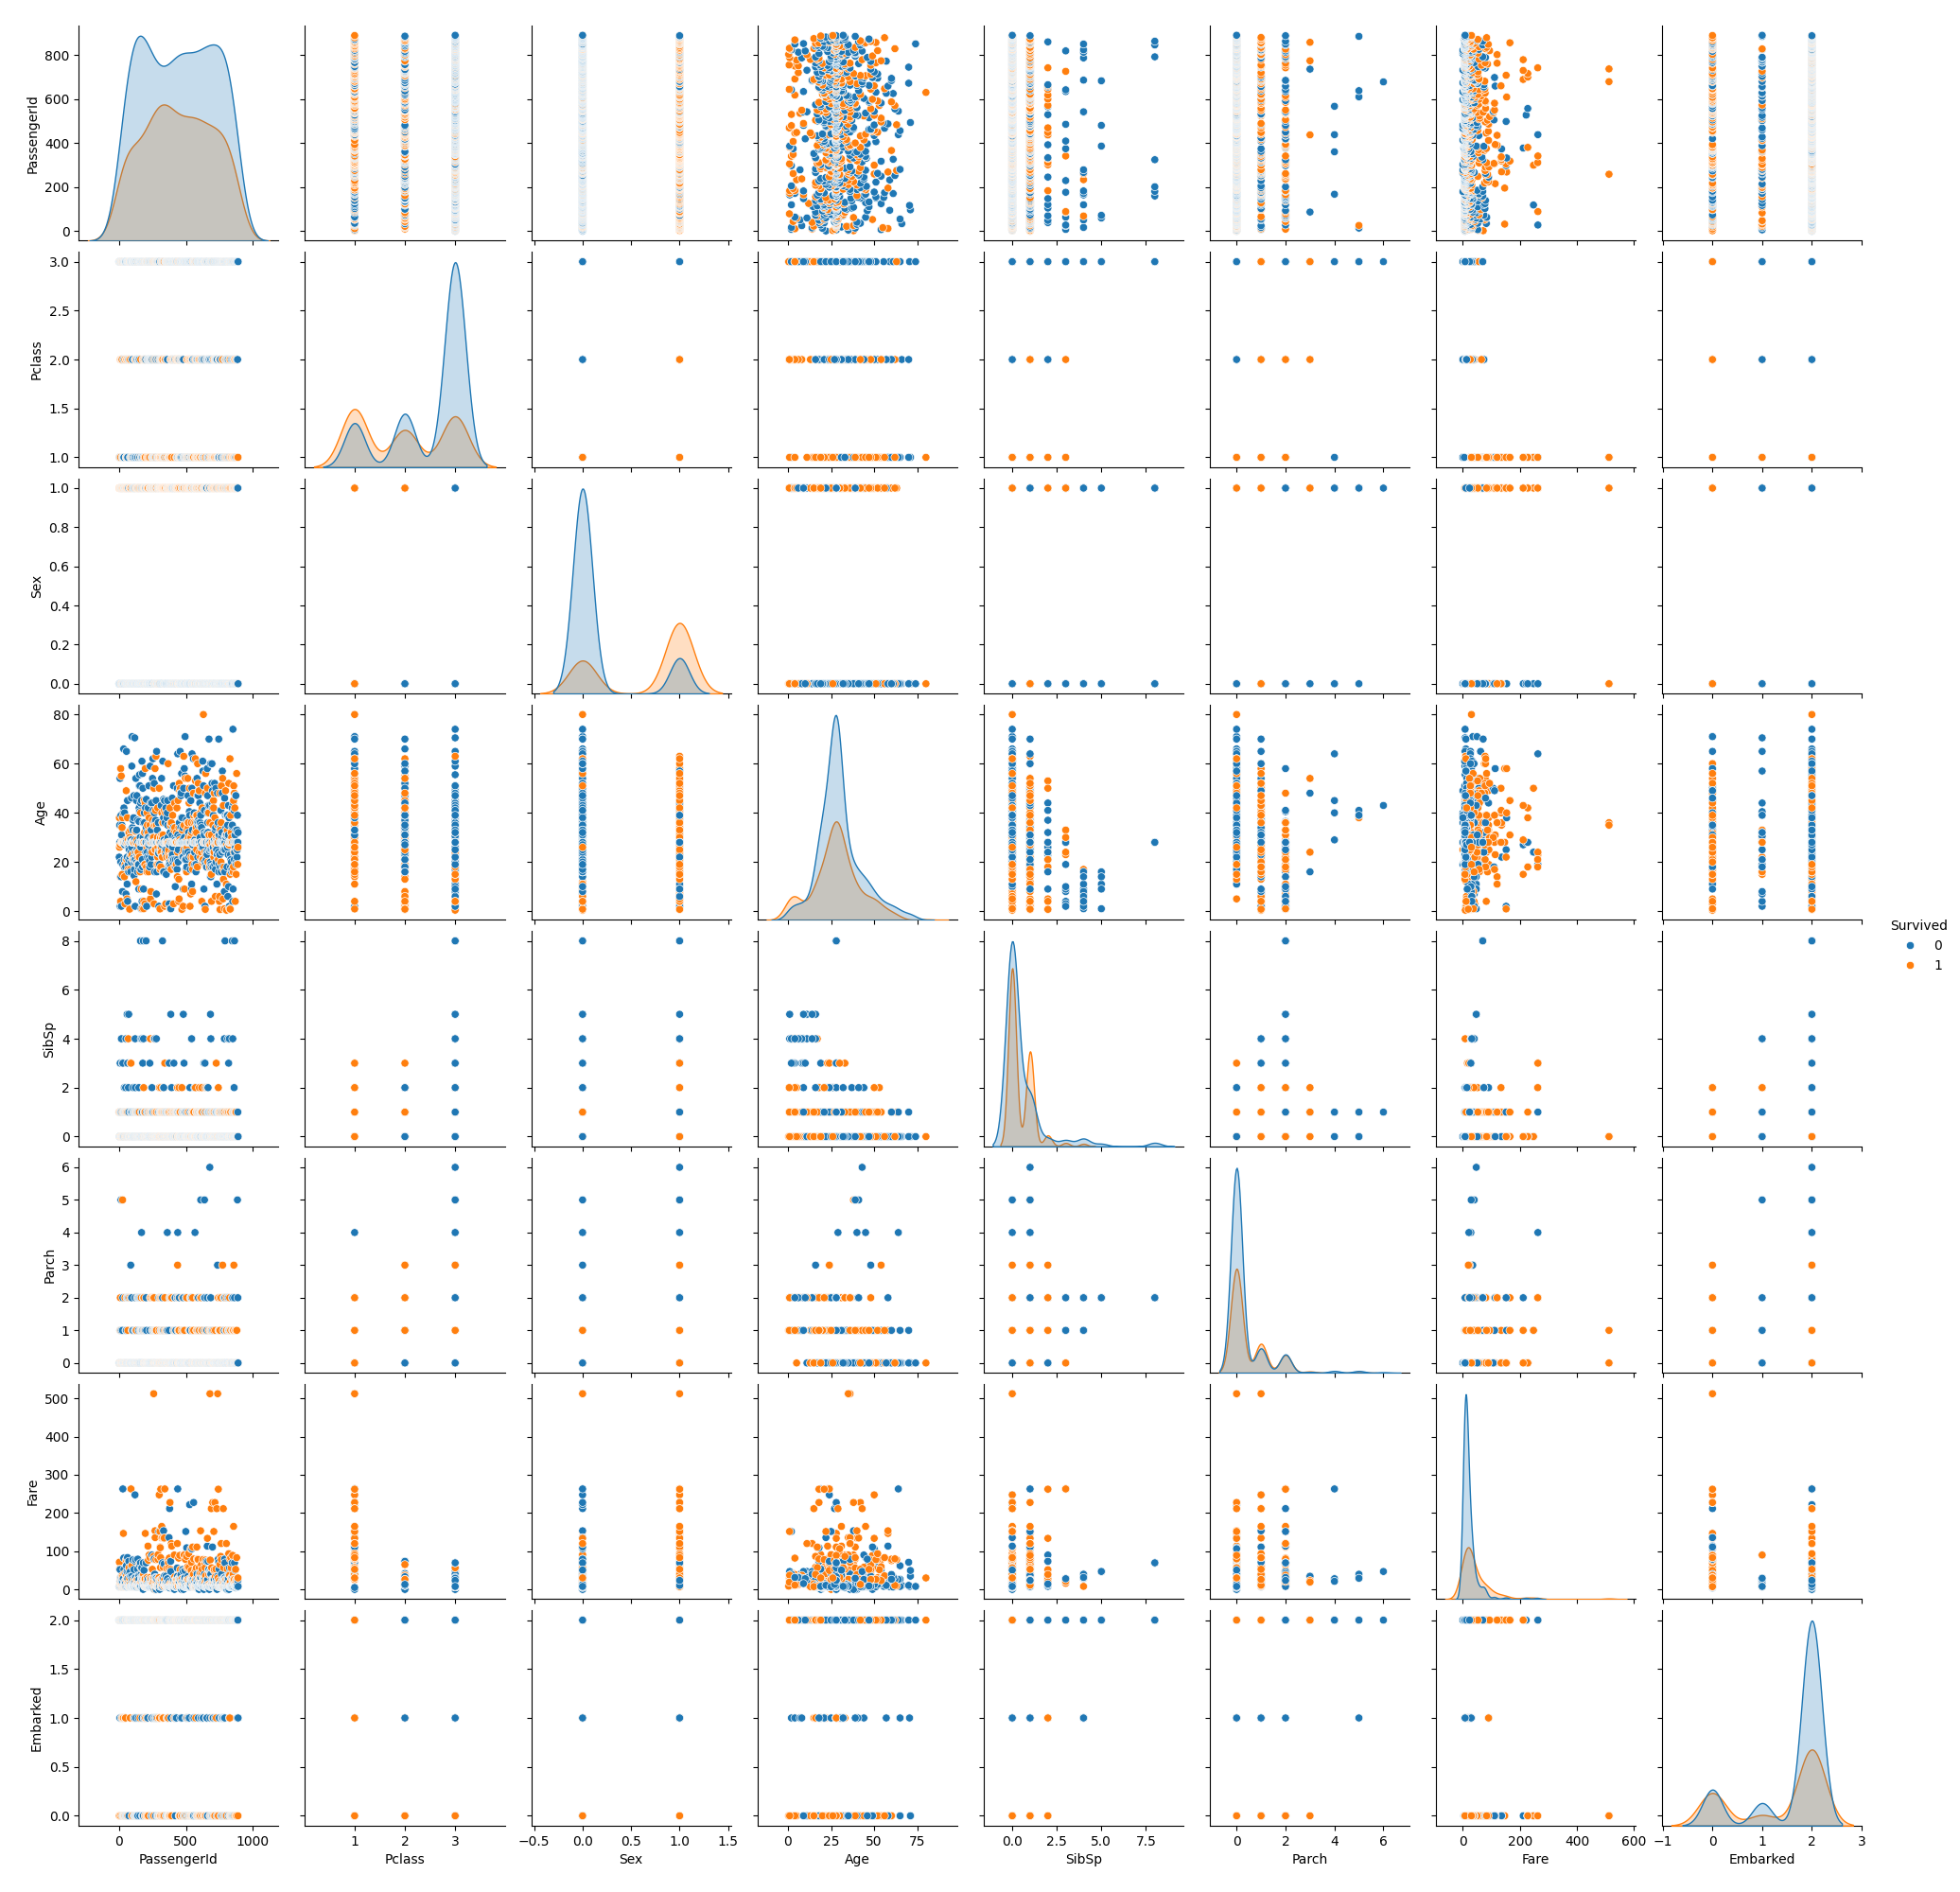

In [178]:
sns.pairplot(processedData, hue="Survived")
plt.show()

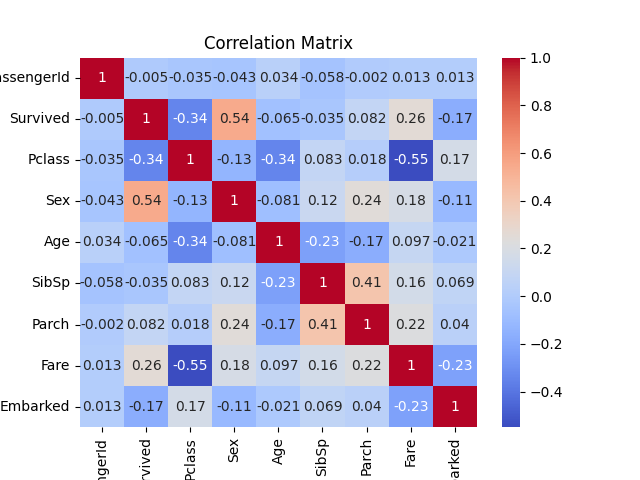

In [169]:
processedDataCorrMatrix = processedData.corr().round(3)
sns.heatmap(processedDataCorrMatrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Survival by Sex

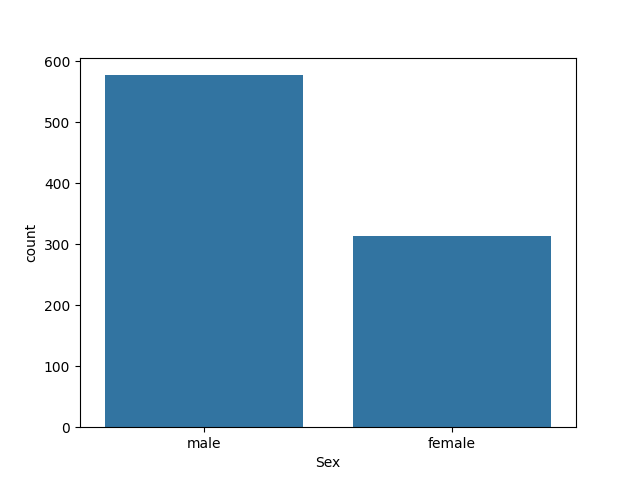

In [170]:
# We don't want to relable our axes
processedDataCategoricalSex = compose(cleanData, embarkedConverter)(data)
sns.countplot(x="Sex", data=processedDataCategoricalSex)
plt.show()
# well that sucks, both sexes are the same color

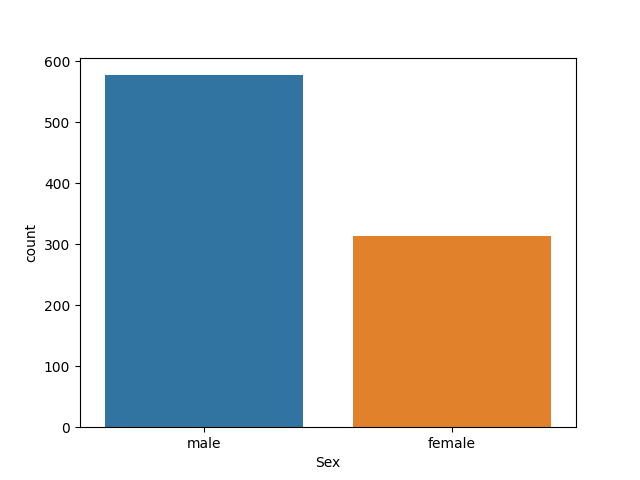

In [171]:
# luckily we can fix that with hue
sns.countplot(x="Sex", hue="Sex", data=processedDataCategoricalSex)
plt.show()

hue is actually really powerful. It enables us to break things down by other variables 

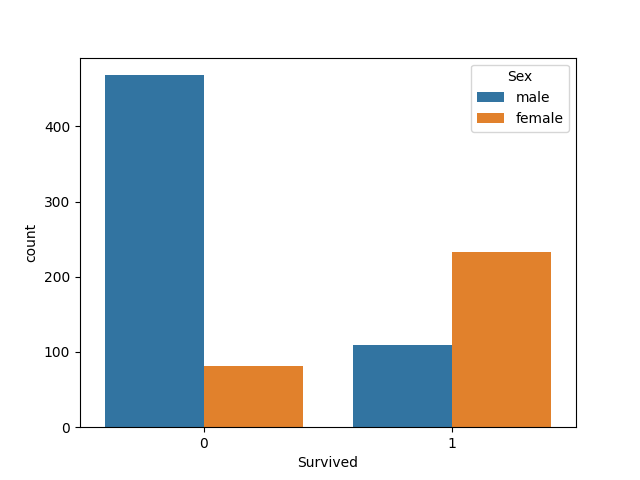

In [172]:
sns.countplot(x="Survived", hue="Sex", data=processedDataCategoricalSex)
plt.show()

### Survival by class

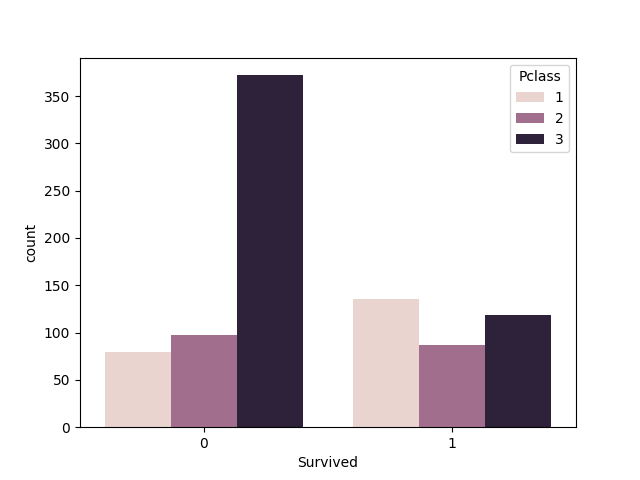

In [121]:
sns.countplot(x="Survived", hue="Pclass", data=processedDataCategoricalSex)
plt.show()

you can even break it down by multiple things, although it requires some work

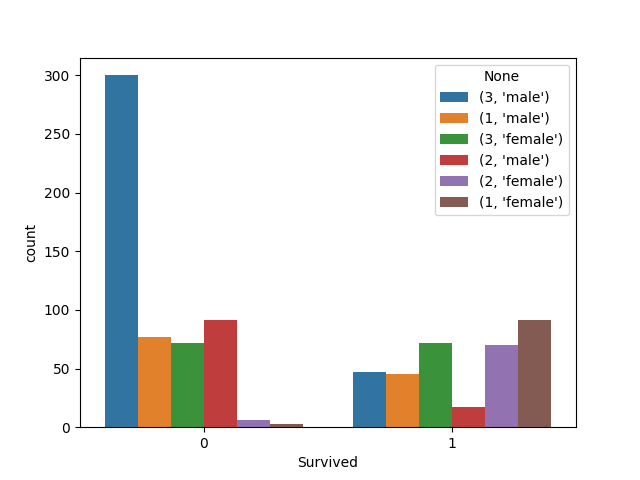

In [122]:
sns.countplot(
    x=processedDataCategoricalSex["Survived"],
    hue=processedDataCategoricalSex[["Pclass", "Sex"]].apply(tuple, axis=1),
)
plt.show()

### Survival by age

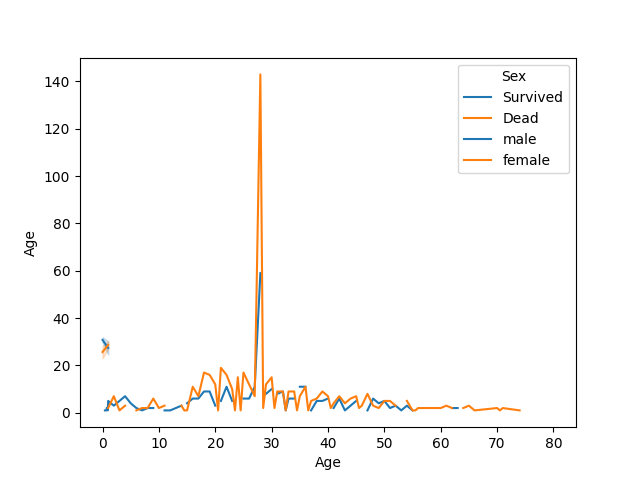

In [115]:
sns.lineplot(x="Survived", y="Age", hue="Sex", data=processedDataCategoricalSex)
plt.show()

That's a horrible way to display the data and doesn't really tell us anything

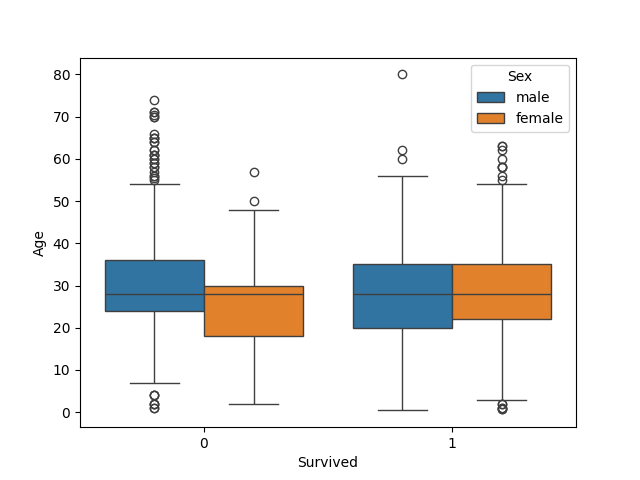

In [118]:
sns.boxplot(x="Survived", y="Age", hue="Sex", data=processedDataCategoricalSex)
plt.show()

you can even overlay plots, admittedy thisn't isn't the best representation...

In [125]:
sns.boxplot(x="Survived", y="Age", hue="Sex", data=processedDataCategoricalSex)
sns.stripplot(x="Survived", y="Age", hue="Sex", data=processedDataCategoricalSex)
plt.show()

### Survival of women by age

You can create new plots that meet certain conditions by modifying your dataframe

In [142]:
df = processedDataCategoricalSex[processedDataCategoricalSex["Sex"] == "female"]
sns.countplot(x="Age", hue="Survived", data=df)
plt.show()

That was unreadable, lets go back to the histogram

In [144]:
df = processedDataCategoricalSex[processedDataCategoricalSex["Sex"] == "female"]
sns.histplot(x="Age", hue="Survived", data=df)
plt.show()

### Survival of men by age

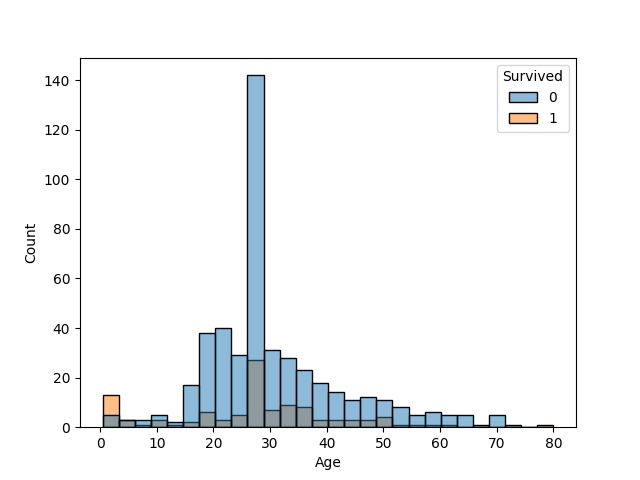

In [145]:
df = processedDataCategoricalSex[processedDataCategoricalSex["Sex"] == "male"]
sns.histplot(x="Age", hue="Survived", data=df)
plt.show()

### Survival of children by age

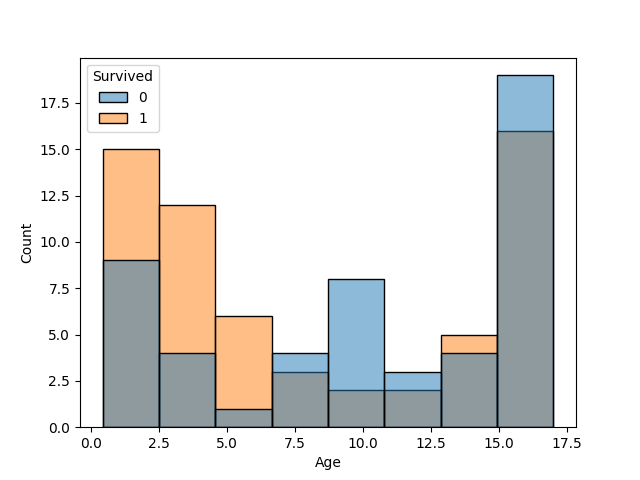

In [151]:
df = processedDataCategoricalSex[processedDataCategoricalSex["Age"] < 18]
sns.histplot(x=df["Age"], hue=df["Survived"])
plt.show()

The data isn't really displayed quite how we want it.  Things seem to be combined weirdly.  lets try a count plot

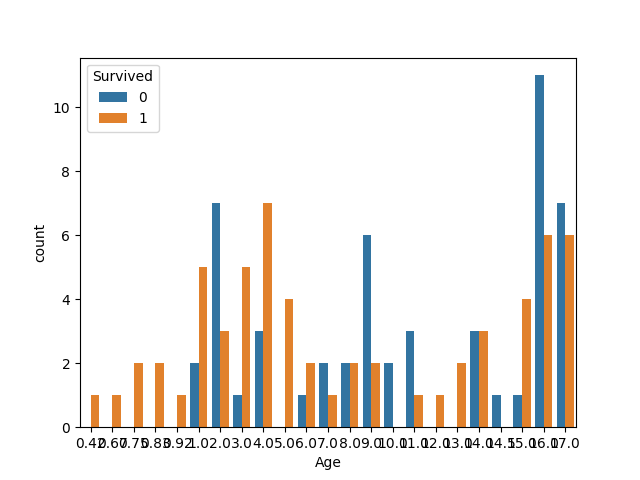

In [152]:
df = processedDataCategoricalSex[processedDataCategoricalSex["Age"] < 18]
sns.countplot(
    x=df["Age"],
    hue=df["Survived"],
)
plt.show()

No thats not right either, lets try modifying the histogram

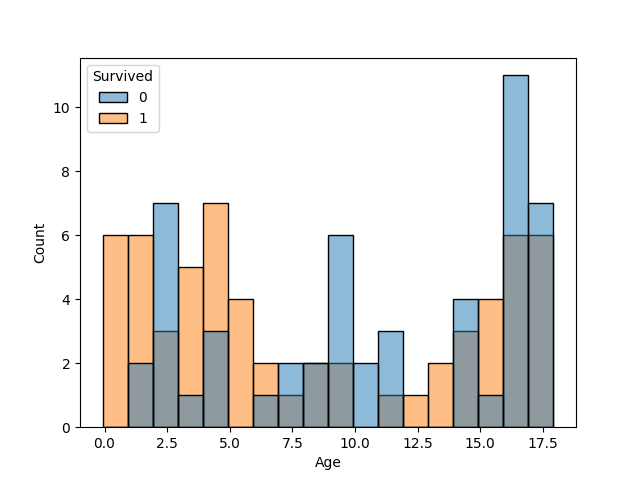

In [156]:
df = processedDataCategoricalSex[processedDataCategoricalSex["Age"] < 18]
sns.histplot(x=df["Age"], hue=df["Survived"], discrete=True)
plt.show()

The problem with looking at the children is that there simply isn't a lot of data.
We can still calculate what your chance of surviving as a child is compared to adults

In [176]:
childDf = processedDataCategoricalSex[processedDataCategoricalSex["Age"] < 18]
adultDf = processedDataCategoricalSex[processedDataCategoricalSex["Age"] >= 18]

boyDf = childDf[childDf["Sex"] == "male"]
girlDf = childDf[childDf["Sex"] == "female"]
manDf = adultDf[adultDf["Sex"] == "male"]
womanDf = adultDf[adultDf["Sex"] == "female"]
survivalPercent = lambda df: df["Survived"].value_counts(normalize=True) * 100
survivalDict = {
    "childSurvive": survivalPercent(childDf),
    "adultSurvive": survivalPercent(adultDf),
    "boySurvive": survivalPercent(boyDf),
    "girlSurvive": survivalPercent(girlDf),
    "manSurvive": survivalPercent(manDf),
    "womanSurvive": survivalPercent(womanDf),
}
survivalDict

{'childSurvive': Survived
 1    53.982301
 0    46.017699
 Name: proportion, dtype: float64,
 'adultSurvive': Survived
 0    63.881748
 1    36.118252
 Name: proportion, dtype: float64,
 'boySurvive': Survived
 0    60.344828
 1    39.655172
 Name: proportion, dtype: float64,
 'girlSurvive': Survived
 1    69.090909
 0    30.909091
 Name: proportion, dtype: float64,
 'manSurvive': Survived
 0    83.429672
 1    16.570328
 Name: proportion, dtype: float64,
 'womanSurvive': Survived
 1    75.289575
 0    24.710425
 Name: proportion, dtype: float64}

In [53]:
data

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [54]:
processedData

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0              1         0       3    0  22.0      1      0   7.2500       2.0
1              2         1       1    1  38.0      1      0  71.2833       0.0
2              3         1       3    1  26.0      0      0   7.9250       2.0
3              4         1       1    1  35.0      1      0  53.1000       2.0
4              5         0       3    0  35.0      0      0   8.0500       2.0
..           ...       ...     ...  ...   ...    ...    ...      ...       ...
886          887         0       2    0  27.0      0      0  13.0000       2.0
887          888         1       1    1  19.0      0      0  30.0000       2.0
888          889         0       3    1  28.0      1      2  23.4500       2.0
889          890         1       1    0  26.0      0      0  30.0000       0.0
890          891         0       3    0  32.0      0      0   7.7500       1.0

[891 rows x 9 columns]

# Machine learning

### Random Forest

In [55]:
X = processedData.drop(["Survived"], axis=1)
y = processedData["Survived"]
randomState = 42

# splitting up the dataset for teesting
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=randomState
)
randomForest = RandomForestClassifier(n_estimators=100, random_state=randomState)
randomForest.fit(X_train, y_train)

y_pred = randomForest.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8268156424581006


### Fine Tuning

In [56]:
paramGrid = {
    "n_estimators": [100, 200, 300],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 6, 8, 10],
    "criterion": ["gini", "entropy"],
}
gridSearch = GridSearchCV(
    estimator=randomForest, param_grid=paramGrid, cv=5, n_jobs=3, scoring="accuracy"
)
gridSearch.fit(X_train, y_train)

bestParams = gridSearch.best_params_

print(f"bestParams: {bestParams}")
# create new model with better parameters
randomForest2 = gridSearch.best_estimator_
# fit the model
randomForest2.fit(X_train, y_train)
y_pred = randomForest2.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

bestParams: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}
Accuracy: 0.8156424581005587


/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/base.py",

### visualize the model

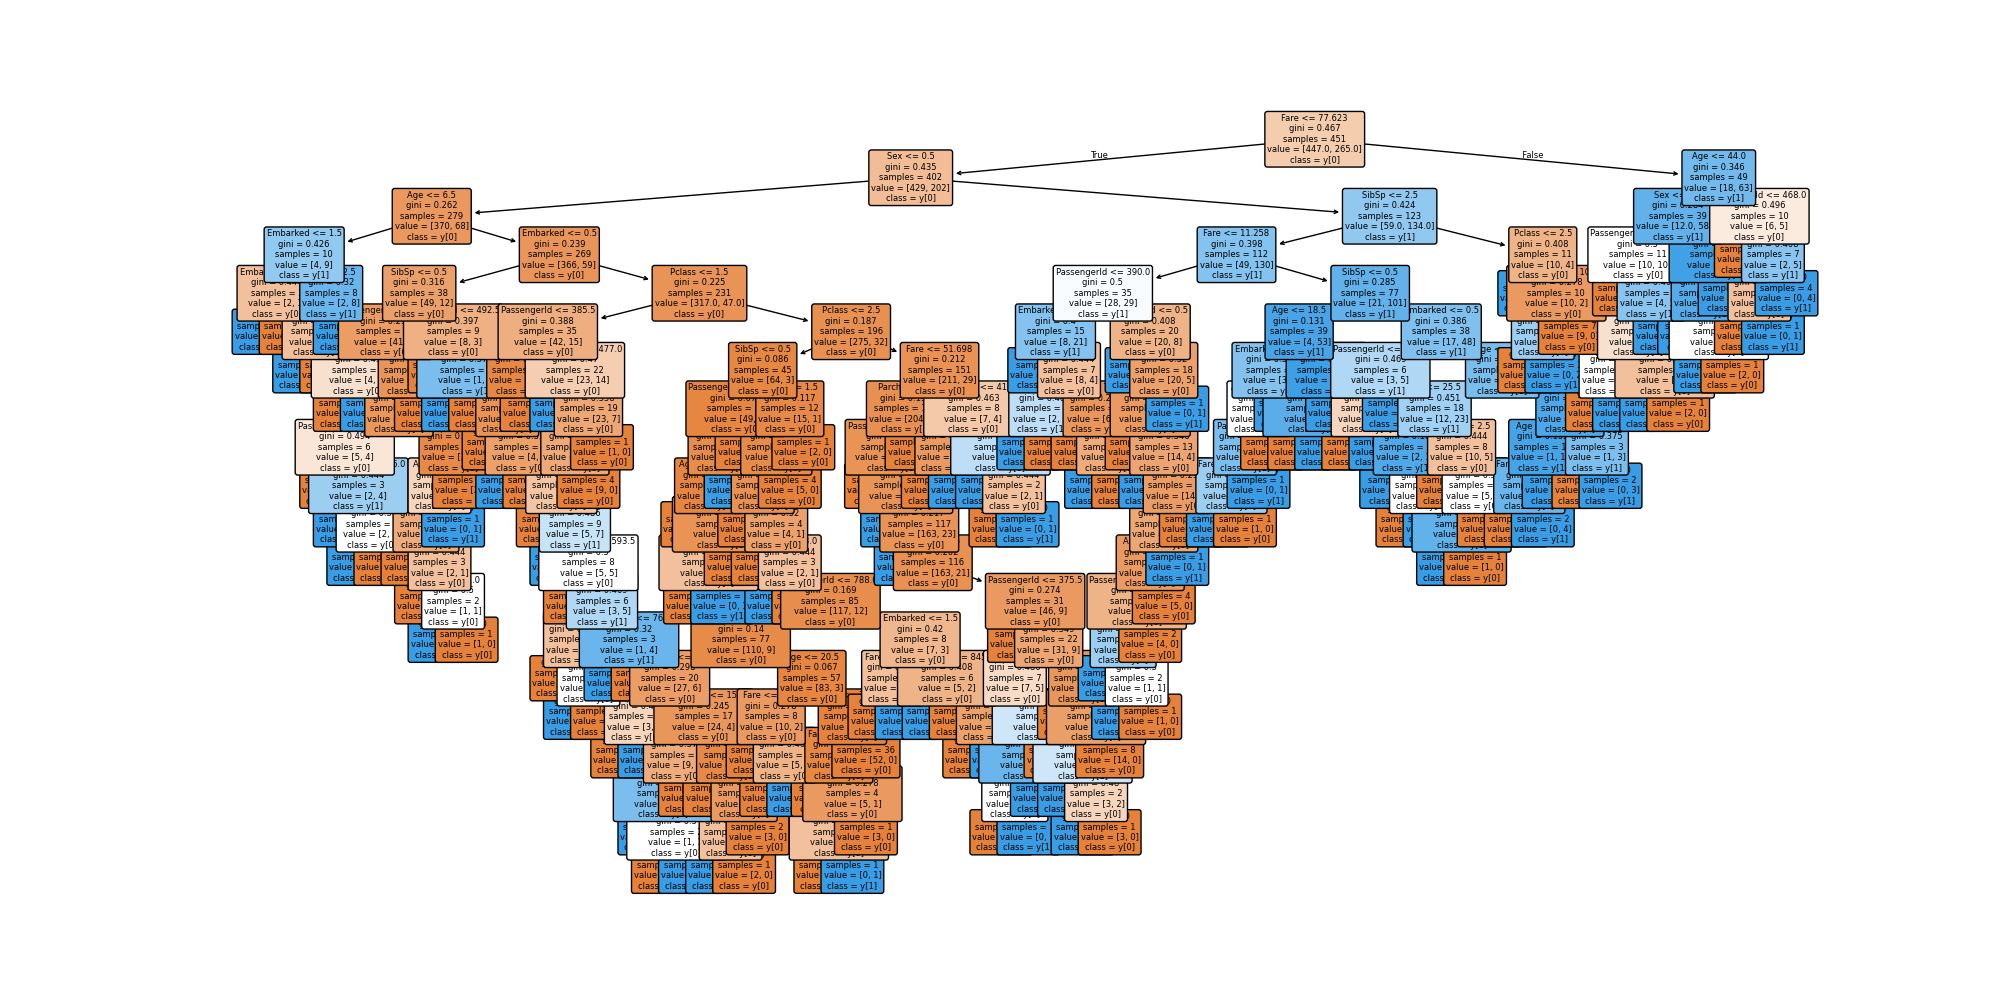

In [57]:
tree = randomForest.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=True,
    filled=True,
    fontsize=6,
    rounded=True,
)
plt.show()

In [58]:
testPassenger = pd.DataFrame.from_dict(
    {
        "PassengerId": [1],
        "Pclass": [1],
        "Sex": [1],
        "Age": [42],
        "SibSp": [1],
        "Parch": [0],
        "Fare": [30],
        "Embarked": [2],
    }
)
testPassengerPrediction = randomForest.predict(testPassenger)
print(testPassengerPrediction)

[1]
